# PEMS dataset
PEMS03, PEMS04, PEMS07 and PEMS08 these four datasets are constructed from four areas in California. All the data was collected from the Caltrans Performance Measurement System (PeMS) and the spatial adjacency matrices for each dataset were built using a distance-based real road network. 

PEMS03 has 358 sensors with a duration of 3 months. 

PEMS04 has 307 sensors with a duration of 2 months. 

PEMS07 has 883 sensors with a duration of 3 months. 

PEMS08 has 170 sensors with a duration of 2 months.

PEMS08 contains the traffic data in San Bernardino from July to August in 2016.

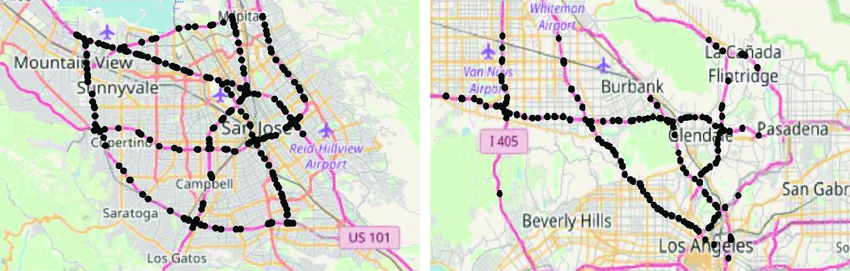

In [116]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import networkx as nx

In [117]:
df = pd.read_csv("data\PEMS08\PEMS08.csv")
df

from   to   cost
0       9  153  310.6
1     153   62  330.9
2      62  111  332.9
3     111   11  324.2
4      11   28  336.0
..    ...  ...    ...
290   154    5  166.3
291    78  107  143.9
292   107   46  236.3
293   118  145  250.6
294   145   96   85.1

[295 rows x 3 columns]

В этой таблице лежит исследуемый граф, в котором вершины - сенсоры, установленные на дорогах, а рёбра и веса на них - расстояния, между соседниими сенсорами.

In [118]:
G = nx.Graph()

SEED = 44
np.random.seed(SEED)

for _, row in df.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['cost'])

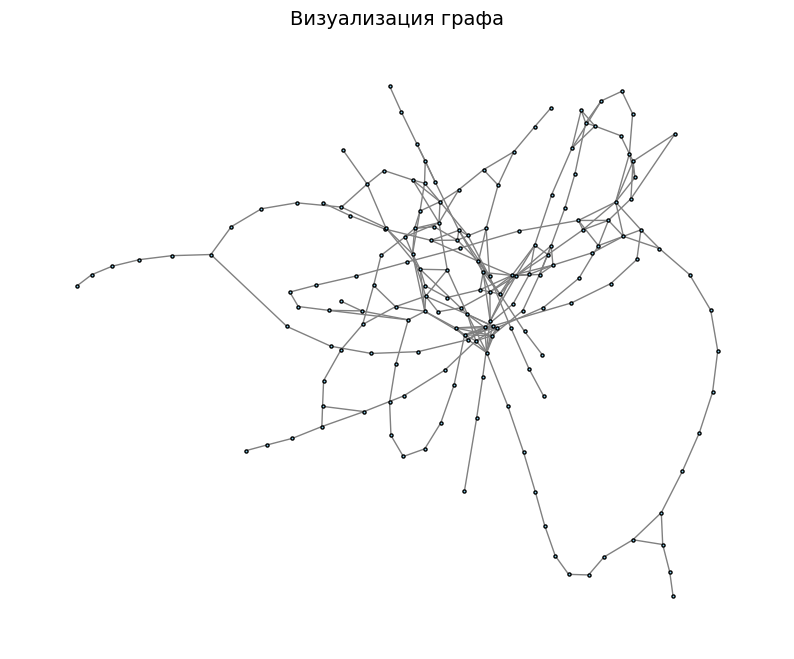

In [119]:
pos = nx.spring_layout(G, seed=SEED, k=0.5, iterations=50)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=5, node_color="skyblue", edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray")

edge_labels = nx.get_edge_attributes(G, 'weight')

plt.title("Визуализация графа", fontsize=14)
plt.axis("off")
plt.show()

In [120]:
edge_x = []
edge_y = []
node_x = []
node_y = []
node_labels = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None]) 
    edge_y.extend([y0, y1, None])

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_labels.append(node)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
))

fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,
    textposition="top center",
    marker=dict(
        size=5,
        color='skyblue',
        line=dict(width=2, color='black')
    ),
    hoverinfo='text'
))

edge_weights = [
    data['weight'] for u, v, data in G.edges(data=True)
]
for i, edge in enumerate(G.edges()):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    mid_x = (x0 + x1) / 2
    mid_y = (y0 + y1) / 2
    fig.add_trace(go.Scatter(
        x=[mid_x],
        y=[mid_y],
        text=[edge_weights[i]],
        mode='text',
        textfont=dict(size=1, color='white'),
        hoverinfo='text'
    ))

fig.update_layout(
    title="Интерактивный граф",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    template="plotly_white",
    width=800,
    height=600
)

fig.show()

Попробую по другому

In [121]:
n_sensors = 170
A = np.zeros((n_sensors, n_sensors))
distA = np.full(shape=(n_sensors, n_sensors), fill_value=np.inf)
distances = []

for _, row in df.iterrows():
    i, j, dist = int(row[0]), int(row[1]), float(row[2])
    A[i, j] = 1
    A[j, i] = 1
    distA[i, j] = dist
    distA[j, i] = dist
    distances.append(dist)

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_14324\3173588965.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



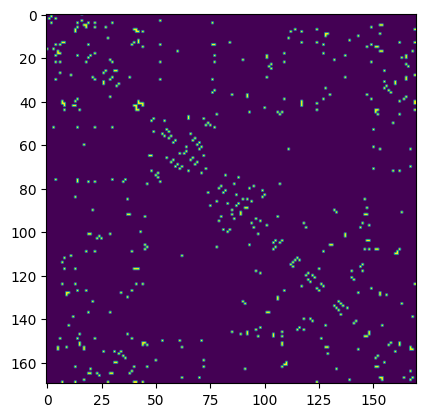

In [122]:
plt.imshow(A)


In [123]:
degrees = np.sum(A, axis=0)

print(f"""Степени вершин:"
       Максимальная : {degrees.max()}
       Средняя : {degrees.mean()}
       Медианная : {np.median(degrees)}""")

Степени вершин:"
       Максимальная : 9.0
       Средняя : 3.223529411764706
       Медианная : 2.0


In [124]:
unique_degrees, deg_counts = np.unique(degrees, return_counts=True)
print(unique_degrees)
print(deg_counts)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[11 77 26 18 13 14  6  3  2]


In [125]:
distances = np.array(distances)
distances.mean()

315.8952542372881

Давайте посчитаем минимальные расстояния от каждой вершины к каждой на этом графе, используя алгоритм Флойда.

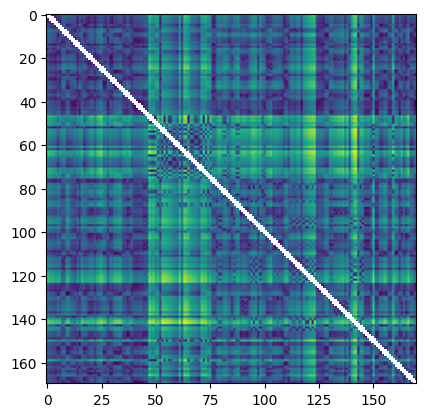

In [126]:
for k in range(n_sensors):
    for u in range(n_sensors):
        for v in range(u + 1, n_sensors):
            distA[u, v] = min(distA[u, v], distA[u, k] + distA[k, v])
            distA[v, u] = distA[u, v]

plt.imshow(distA)

In [127]:
distA[63, 70]


3075.5

In [128]:
data = np.load("data\PEMS08\PEMS08.npz")
data = data["data"]
data

array([[[1.330e+02, 6.030e-02, 6.580e+01],
        [2.100e+02, 5.890e-02, 6.960e+01],
        [1.240e+02, 3.580e-02, 6.580e+01],
        ...,
        [7.400e+01, 2.131e-01, 6.530e+01],
        [9.400e+01, 2.260e-02, 6.800e+01],
        [6.000e+00, 3.100e-03, 6.500e+01]],

       [[1.140e+02, 5.320e-02, 6.690e+01],
        [1.850e+02, 5.500e-02, 6.850e+01],
        [1.190e+02, 3.390e-02, 6.500e+01],
        ...,
        [7.300e+01, 1.469e-01, 3.720e+01],
        [8.400e+01, 1.890e-02, 6.870e+01],
        [4.000e+00, 1.800e-03, 6.500e+01]],

       [[1.400e+02, 6.220e-02, 6.680e+01],
        [1.710e+02, 4.660e-02, 6.990e+01],
        [1.070e+02, 3.360e-02, 6.380e+01],
        ...,
        [7.000e+01, 5.860e-02, 3.400e+01],
        [8.200e+01, 2.200e-02, 6.700e+01],
        [4.000e+00, 2.100e-03, 6.490e+01]],

       ...,

       [[1.200e+02, 5.810e-02, 6.330e+01],
        [1.760e+02, 5.290e-02, 6.680e+01],
        [1.190e+02, 5.180e-02, 5.610e+01],
        ...,
        [4.700e+01, 1.551e

In [129]:
data.shape

(17856, 170, 3)

У нас есть 17856 временных отметок, 170 точек наблюдения и 3 измеряемых параметра.\
Посмотрим на график.

In [130]:
import plotly.graph_objects as go

sensor_index = 0 
time_steps = list(range(data.shape[0]))

n_cars = data[:, sensor_index, 0]
volume = data[:, sensor_index, 1]
density = data[:, sensor_index, 2]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_steps, y=n_cars,
    mode='lines',
    name='1',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=time_steps, y=volume,
    mode='lines',
    name='2',
    line=dict(color='orange', width=2)
))

fig.add_trace(go.Scatter(
    x=time_steps, y=density,
    mode='lines',
    name='3',
    line=dict(color='green', width=2)
))

fig.update_layout(
    title=f"Данные сенсора {sensor_index} во времени",
    xaxis_title="Временные шаги",
    yaxis_title="Значения",
    legend=dict(title="Параметры"),
    template="plotly_white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    width=800,
    height=500
)

fig.show()


In [131]:
fig = px.line(x=time_steps, y=n_cars)
fig.update_layout(
    title=f"Данные сенсора {sensor_index}",
    xaxis_title="Временные шаги",
    yaxis_title="Значения",
)
fig.show()

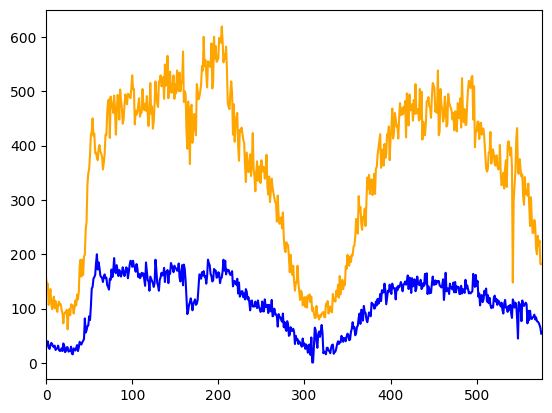

In [132]:
data0 = data[:, 3, 0]
data16 = data[:, 16, 0]

plt.plot(data0[5:288 * 2 + 5], color="orange")
plt.plot(data16[:288 * 2], color="blue")
plt.xlim(0, 288 * 2)
plt.show()

In [133]:
for d in range(-10, 10):
    corr = np.corrcoef(data0[288 + d:288 + 288 * 2 + d], data16[288:288 + 288 * 2])[0][1]
    print(f'd : {d}, corr : {corr}')
    

d : -10, corr : 0.8921865954430429
d : -9, corr : 0.895168009832103
d : -8, corr : 0.9047308070345131
d : -7, corr : 0.9096400067202662
d : -6, corr : 0.9153957722358013
d : -5, corr : 0.9211113578010138
d : -4, corr : 0.9251916025182467
d : -3, corr : 0.9319734038502284
d : -2, corr : 0.9429748935367637
d : -1, corr : 0.9658741102366759
d : 0, corr : 0.9594537570045999
d : 1, corr : 0.9516881025715495
d : 2, corr : 0.9461972512121719
d : 3, corr : 0.9445716214477974
d : 4, corr : 0.9417314622516725
d : 5, corr : 0.9425359200915955
d : 6, corr : 0.9437303434257803
d : 7, corr : 0.9410499360504779
d : 8, corr : 0.9394332117783034
d : 9, corr : 0.937562260495132


### Возьмем два удаленных друг от друга сенсора и проверим ряды на кореллированность со сдвигом.

In [135]:
from tqdm import tqdm
week = 24 * 12 * 7
day = 24 * 12

i1 = 63; i2 = 70
print(distA[i1, i2])
data1 = data[:, i1, 0]
data2 = data[:, i2, 0]

corrs = []

for d in range(day):
    corr = np.corrcoef(data1[d : day + d], data2[:day])[0][1]
    corrs.append(corr)

fig = px.line(x=range(day), y=corrs)
# fig.
# fig.add_legend(
#     x="Shift",
#     y="Correlation",
#     name="Correlation between 3 and 16 sensors"
# )
fig.show()

3075.5


Посмотрим на сенсоры, которые располагаются недалеко друг от друга

In [140]:
i1 = 66; i2 = 67
print(distA[i1, i2])
data1 = data[:, i1, 0]
data2 = data[:, i2, 0]

corrs = []

for d in range(day):
    corr = np.corrcoef(data1[d : day + d], data2[:day])[0][1]
    corrs.append(corr)

fig = px.line(x=range(day), y=corrs)
fig.show()

299.5


Исходя из того, что интервалы между считыванием 5 минут, можем выдвинуть гипотезу, что на прямом участке дороги сенсоры, которые находятся друг от друга на расстоянии $v_{mean} * t_5 \approx 5 km$. Предполагая то, что автомобиль за 5 минут может проехать 5 километров, мы должны найти два сенсора на расстоянии $l = 5km$ и проверить их на кореллированность. Исходя из гипотезы, они должны быть кореллированы со сдвигом 1.

In [141]:
for d in [0, 4]:
    print(np.corrcoef(data[:, 0, 0][d : week + d], data[:, 10, 0][:week])[0][1])

0.8032031383370998
0.8215276504994874


100%|██████████| 170/170 [02:00<00:00,  1.41it/s]


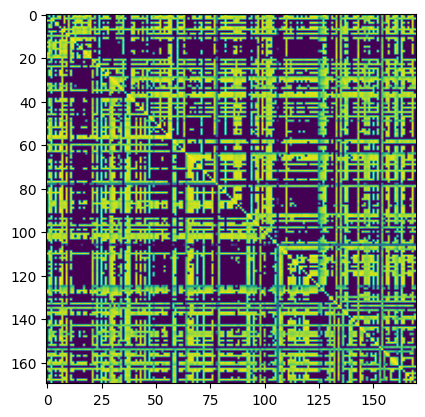

In [142]:
n_sensors = 170
range_check = 120 # За такое время ТОЧНО можно доехать из одной точки в другую.
corr_mat = np.eye(n_sensors) # Давайте сохранять в i, j максимальную корреляцию для двух сенсоров i, j
ans_mat = np.diag([i for i in range(1, n_sensors + 1)])

for i in tqdm(range(n_sensors)):
    for j in range(i, n_sensors):
        coeffs = [np.corrcoef(data[:, i, 0][d : day + d], data[:, j, 0][:day])[0][1] for d in range(range_check)]
        best_d_corr = np.argmax(coeffs)
        if (best_d_corr > 0):
            corr_mat[i, j] = coeffs[best_d_corr]
            corr_mat[j, i] = corr_mat[i, j]
            ans_mat[i, j] = best_d_corr
            ans_mat[j, i] = ans_mat[i, j]
            
plt.imshow(corr_mat)

Интересный результат.

Если присмотреться к данным, (из предположения, что циклы у нас суточные), временной интервал между двумя измерениями - 5 минут.

In [143]:
fig = px.line(x=time_steps, y=volume)
fig.update_layout(
    title=f"Данные сенсора {sensor_index}",
    xaxis_title="Временные шаги",
    yaxis_title="Значения",
)
fig.show()

In [144]:
fig = px.line(x=time_steps, y=density)
fig.update_layout(
    title=f"Данные сенсора {sensor_index}",
    xaxis_title="Временные шаги",
    yaxis_title="Значения",
)
fig.show()